# Installs

In [1]:
!pip install transformers
!pip install salesforce-lavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Grad-CAM for visual language tasks

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.ndimage import filters
import skimage.transform as skimage_transform
import torch
import torch.nn.functional as F
import transformers
from lavis.models import load_model, load_model_and_preprocess, BlipITM
from lavis.processors import load_processor

## Captioning

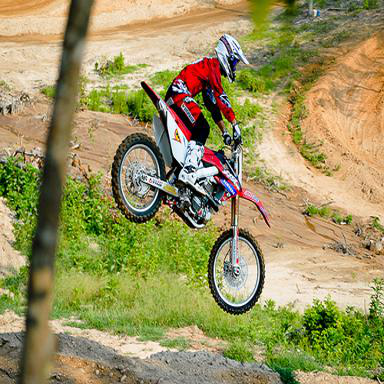

In [3]:
raw_image = Image.open('/content/3670907052_c827593564.jpg').convert("RGB")
raw_image.show()

In [4]:
caption_model, vis_processors, txt_processors = load_model_and_preprocess("blip_caption", "large_coco")
image = vis_processors["eval"](raw_image).unsqueeze(0)
samples = {"image": image}
captions = caption_model.generate(samples)
text_input = captions[0]
del caption_model
text_input

'a person on a dirt bike doing a trick'

## Image/Text Matching

In [5]:
model = load_model("blip_image_text_matching", "large")
image_processor = load_processor("blip_image_eval").build(image_size=384)
text_processor = load_processor("blip_caption")
tokenizer = BlipITM.init_tokenizer()

In [6]:
visual_input = image_processor(raw_image).unsqueeze(0)
tokenized_text = transformers.BatchEncoding({k:v for (k,v) in zip(tokenizer(text_input).keys(), [torch.tensor(x) for x in tokenizer(text_input).values()])})

### Compute Grad-Cam

In [7]:
def compute_gradcam(model, visual_input, text_input, tokenized_text, block_num=6):
    model.text_encoder.base_model.base_model.encoder.layer[
        block_num
    ].crossattention.self.save_attention = True

    output = model({"image": visual_input, "text_input": text_input}, match_head="itm")
    loss = output[:, 1].sum()

    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mask = tokenized_text.attention_mask.view(
            tokenized_text.attention_mask.size(0), 1, -1, 1, 1
        )  # (bsz,1,token_len, 1,1)
        token_length = tokenized_text.attention_mask.sum(dim=-1) - 2
        token_length = token_length.cpu()
        # grads and cams [bsz, num_head, seq_len, image_patch]
        grads = model.text_encoder.base_model.base_model.encoder.layer[
            block_num
        ].crossattention.self.get_attn_gradients()
        cams = model.text_encoder.base_model.base_model.encoder.layer[
            block_num
        ].crossattention.self.get_attention_map()

        # assume using vit with 576 num image patch
        cams = cams[:, :, :, 1:].reshape(visual_input.size(0), 12, -1, 24, 24) * mask
        grads = (
            grads[:, :, :, 1:].clamp(0).reshape(visual_input.size(0), 12, -1, 24, 24)
            * mask
        )

        gradcams = cams * grads
        gradcam_list = []

        for ind in range(visual_input.size(0)):
            token_length_ = token_length.item()
            gradcam = gradcams[ind].mean(0).cpu().detach()
            # [enc token gradcam, average gradcam across token, gradcam for individual token]
            gradcam = torch.cat(
                (
                    gradcam[0:1, :],
                    gradcam[1 : token_length_ + 1, :].sum(dim=0, keepdim=True)
                    / token_length_,
                    gradcam[1:, :],
                )
            )
            gradcam_list.append(gradcam)
            
    return gradcam_list, output

In [8]:
gradcam_list, output = compute_gradcam(model=model, visual_input=visual_input, text_input=text_input, tokenized_text=tokenized_text)
del model

### Visualization

In [9]:
def visualize_gradcam_for_each_token(image, gradcam_list, tokenized_text, image_path):
    def getAttMap(img, attMap, blur=True, overlap=True):
        attMap -= attMap.min()
        if attMap.max() > 0:
            attMap /= attMap.max()
        attMap = skimage_transform.resize(attMap, (img.shape[:2]), order=3, mode="constant")
        if blur:
            attMap = filters.gaussian_filter(attMap, 0.02 * max(img.shape[:2]))
            attMap -= attMap.min()
            attMap /= attMap.max()
        cmap = plt.get_cmap("jet")
        attMapV = cmap(attMap)
        attMapV = np.delete(attMapV, 3, 2)
        if overlap:
            attMap = (
                1 * (1 - attMap ** 0.7).reshape(attMap.shape + (1,)) * img
                + (attMap ** 0.7).reshape(attMap.shape + (1,)) * attMapV
            )
        return attMap

    tokens = tokenizer.convert_ids_to_tokens(tokenized_text.input_ids.squeeze(0))
    gradcams = gradcam_list[0][2:-1]

    num_image = len(tokens) - 1
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    rgb_image = cv2.imread(image_path)[:, :, ::-1]
    rgb_image = np.float32(rgb_image) / 255

    ax[0].imshow(rgb_image)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_xlabel("Image")

    for i, token in enumerate(tokens[1:-1]):
        gradcam_tensor = gradcams[i]
        gradcam_image = getAttMap(rgb_image, gradcam_tensor.numpy())
        ax[i + 1].imshow(gradcam_image)
        ax[i + 1].set_yticks([])
        ax[i + 1].set_xticks([])
        ax[i + 1].set_xlabel(token)

    plt.savefig('bike_attention.jpg')
    plt.show()

In [10]:
# Example usage:
image_path = '/content/3670907052_c827593564.jpg'
visualize_gradcam_for_each_token(image, gradcam_list, tokenized_text, image_path)

Output hidden; open in https://colab.research.google.com to view.